In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from data import FloodEventDataset
from utils import file_utils

### Dataset Visualization

In [2]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

In [3]:
mode = 'train' # 'train' or 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

delta_t = dataset_parameters['timestep_interval']
dataset = FloodEventDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_shp_file=dataset_parameters['nodes_shp_file'],
    edges_shp_file=dataset_parameters['edges_shp_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    timestep_interval=delta_t,
    spin_up_time=dataset_parameters['spin_up_time'],
    time_from_peak=dataset_parameters['time_from_peak'],
    inflow_boundary_nodes=dataset_parameters['inflow_boundary_nodes'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
    with_global_mass_loss=False,
    with_local_mass_loss=False,
    force_reload=True,
)

Processing Flood Event Dataset...
Saved constant values to data\datasets\processed\constant_values.npz
Saved dynamic values for event 1 to data\datasets\processed\dynamic_values_event_1.npz
Saved dynamic values for event 2 to data\datasets\processed\dynamic_values_event_2.npz
Saved dynamic values for event 3 to data\datasets\processed\dynamic_values_event_3.npz
Saved dynamic values for event 4 to data\datasets\processed\dynamic_values_event_4.npz
Saved dynamic values for event 5 to data\datasets\processed\dynamic_values_event_5.npz
Saved dynamic values for event 6 to data\datasets\processed\dynamic_values_event_6.npz
Saved dynamic values for event 7 to data\datasets\processed\dynamic_values_event_7.npz
Saved dynamic values for event 8 to data\datasets\processed\dynamic_values_event_8.npz
Saved dynamic values for event 9 to data\datasets\processed\dynamic_values_event_9.npz
Saved dynamic values for event 10 to data\datasets\processed\dynamic_values_event_10.npz
Saved dynamic values for 

In [4]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 37
Total number of timesteps: 6463


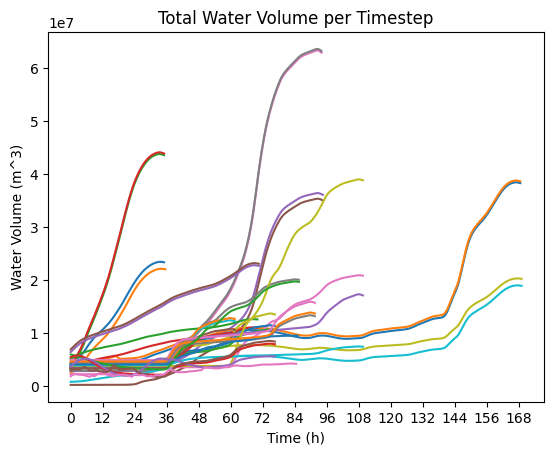

In [5]:
if mode == 'train':
    start_ts = 0
    end_ts = None
else:  # mode == 'test'
    rollout_start = config['testing_parameters']['rollout_start']
    rollout_timesteps = config['testing_parameters']['rollout_timesteps']
    start_ts = rollout_start
    end_ts = (start_ts + rollout_timesteps) if rollout_timesteps is not None else None

delta_t_in_hours = delta_t / 3600
num_events = len(dataset.hec_ras_run_ids)
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]

longest_hours_elapsed = []
for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_nodes_paths):
    dynamic_nodes = np.load(path)['dynamic_nodes'][2:]  # Skip the first two timesteps as this is only used for previous timestep data
    water_volume_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')
    water_volume = dynamic_nodes[start_ts:end_ts, :, water_volume_idx]
    water_volume = dataset.normalizer.denormalize('water_volume', water_volume)
    total_water_volume = water_volume.sum(axis=1)
    hours_elapsed = np.arange(len(total_water_volume)) * delta_t_in_hours
    plt.plot(hours_elapsed, total_water_volume, label=f'Run {run_id}')
    if len(hours_elapsed) > len(longest_hours_elapsed):
        longest_hours_elapsed = hours_elapsed

tick_interval_in_hours = 12
plt.title(f'Total Water Volume per Timestep')
plt.xlabel('Time (h)')
interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
plt.xticks(longest_hours_elapsed[interval_ticks])
plt.ylabel('Water Volume (m^3)')
# plt.legend()
plt.show()

In [6]:
event_end_idx = [*dataset.event_start_idx[1:], dataset.total_rollout_timesteps]
event_size = np.diff(event_end_idx, prepend=0)

for i, run_id in enumerate(dataset.hec_ras_run_ids):
    print(f'Run {run_id} - Event Size: {event_size[i]} timesteps')

Run 1 - Event Size: 70 timesteps
Run 2 - Event Size: 71 timesteps
Run 3 - Event Size: 70 timesteps
Run 4 - Event Size: 70 timesteps
Run 5 - Event Size: 189 timesteps
Run 6 - Event Size: 189 timesteps
Run 7 - Event Size: 188 timesteps
Run 8 - Event Size: 188 timesteps
Run 9 - Event Size: 338 timesteps
Run 10 - Event Size: 338 timesteps
Run 11 - Event Size: 337 timesteps
Run 12 - Event Size: 337 timesteps
Run 13 - Event Size: 140 timesteps
Run 14 - Event Size: 140 timesteps
Run 15 - Event Size: 141 timesteps
Run 16 - Event Size: 141 timesteps
Run 17 - Event Size: 219 timesteps
Run 18 - Event Size: 171 timesteps
Run 19 - Event Size: 153 timesteps
Run 20 - Event Size: 123 timesteps
Run 21 - Event Size: 153 timesteps
Run 22 - Event Size: 123 timesteps
Run 23 - Event Size: 153 timesteps
Run 24 - Event Size: 123 timesteps
Run 25 - Event Size: 219 timesteps
Run 26 - Event Size: 123 timesteps
Run 27 - Event Size: 183 timesteps
Run 28 - Event Size: 183 timesteps
Run 29 - Event Size: 219 timestep

Nodes with the highest water volume difference:
Node 1022: 151029.70 m
Node 1026: 149075.56 m
Node 1023: 141392.59 m
Node 208: 132189.38 m
Node 1082: 131184.88 m
Node 329: 127891.97 m
Node 1081: 119323.19 m
Node 209: 118207.24 m
Node 443: 104703.66 m
Node 338: 96291.54 m
Node 444: 95703.44 m
Node 445: 94755.18 m
Node 434: 93861.33 m
Node 442: 93799.40 m
Node 459: 93524.97 m


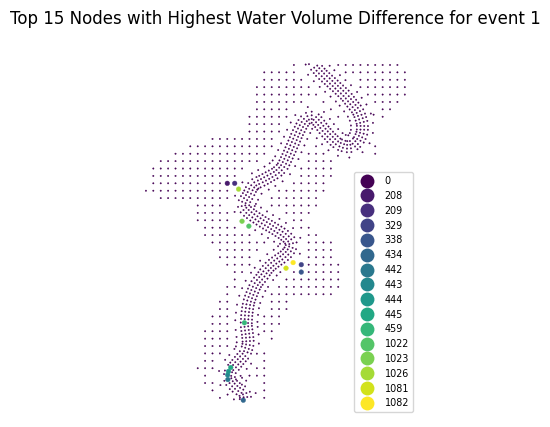

In [7]:
def get_highest_diff_water_volume_nodes(dataset: FloodEventDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]

    dynamic_nodes = np.load(dynamic_nodes_paths[event_idx])['dynamic_nodes']
    water_volume_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')
    water_volume = dynamic_nodes[:, :, water_volume_idx]
    water_volume = dataset.normalizer.denormalize('water_volume', water_volume)
    wv_diff = np.abs(np.diff(water_volume, axis=0))
    wv_diff_per_node = wv_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wv_diff_per_node)[-k:][::-1].tolist()
    top_k_wd_diff = wv_diff_per_node[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff

def get_node_df(dataset: FloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
    nodes_shp_path = dataset.raw_paths[0]
    node_df = gpd.read_file(nodes_shp_path)

    if no_ghost:
        node_df = node_df[~node_df['CC_index'].isin(dataset.boundary_condition.ghost_nodes)]

    return node_df

def plot_cell_map(node_df: gpd.GeoDataFrame, value: np.ndarray=None, cmap=None):
    default_marker_size = 1
    shared_plot_kwargs = {
        'linewidth': 0.3,
        'markersize': default_marker_size,
    }

    if value is not None:
        value_column = 'is_flooded'
        node_df[value_column] = value
        if cmap is None:
            cmap = plt.get_cmap('seismic_r') 
        markersize = (value.astype(bool).astype(int) * 10) + default_marker_size
        shared_plot_kwargs.update({
            'markersize': markersize,
            'cmap': cmap,
            'column': value_column,
            'legend': True,
            'legend_kwds': {
                'loc': 'lower right',
                'fontsize': 'x-small',
            },
        })

    node_df.plot(**shared_plot_kwargs)
    plt.axis('off')

EVENT_IDX = 0  # Change this to the desired event index
k = 15  # Number of top nodes to retrieve

top_k_diff_idx, top_k_wd_diff = get_highest_diff_water_volume_nodes(dataset, EVENT_IDX, k=k)
print('Nodes with the highest water volume difference:')
for idx, wd in zip(top_k_diff_idx, top_k_wd_diff):
    print(f"Node {idx}: {wd:.2f} m")

node_df = get_node_df(dataset)
highlight = np.zeros(len(node_df), dtype=object)
highlight[top_k_diff_idx] = top_k_diff_idx

plot_cell_map(node_df, value=highlight, cmap='viridis')
plt.title(f'Top {k} Nodes with Highest Water Volume Difference for event {dataset.hec_ras_run_ids[EVENT_IDX]}')
plt.show()

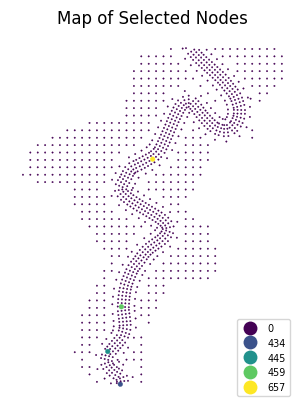

In [8]:
highlight_node_idx = [445, 657, 459, 434]
highlight = np.zeros(len(node_df), dtype=object)
highlight[highlight_node_idx] = highlight_node_idx

plot_cell_map(node_df, value=highlight, cmap='viridis')
plt.title(f'Map of Selected Nodes')
plt.show()

In [9]:
feature_stats_path = dataset.processed_paths[1]
feature_stats = file_utils.read_yaml_file(feature_stats_path)
print("Feature statistics:")
for feature_name, stats in feature_stats.items():
    print(f"{feature_name}")
    print(f"\tMean: {stats['mean']:.4f}")
    print(f"\tStd: {stats['std']:.4f}")
    print(f"\tMin: {stats['min']:.4f}")
    print(f"\tMax: {stats['max']:.4f}")

Feature statistics:
area
	Mean: 27849.5664
	Std: 17814.3047
	Min: 0.0000
	Max: 117583.6875
elevation
	Mean: 105.5253
	Std: 43.6278
	Min: 0.0000
	Max: 319.1630
face_flow
	Mean: 8.8636
	Std: 261.0013
	Min: -6193.0718
	Max: 8188.7954
face_length
	Mean: 138.3993
	Std: 57.5719
	Min: 0.0000
	Max: 396.0271
length
	Mean: 165.2974
	Std: 66.8251
	Min: 0.0000
	Max: 473.5630
rainfall
	Mean: 117.3495
	Std: 123.1138
	Min: 0.0000
	Max: 2331.6875
roughness
	Mean: 0.0821
	Std: 0.0307
	Min: 0.0000
	Max: 0.1000
slope
	Mean: 0.0012
	Std: 0.1273
	Min: -0.6383
	Max: 0.6721
water_volume
	Mean: 8574.1104
	Std: 17754.7324
	Min: 0.0000
	Max: 391150.8750


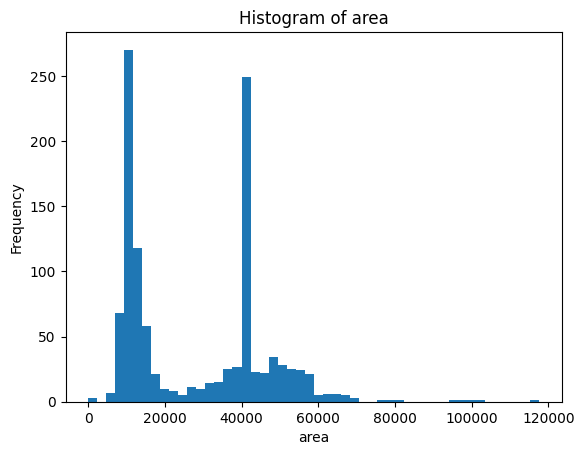

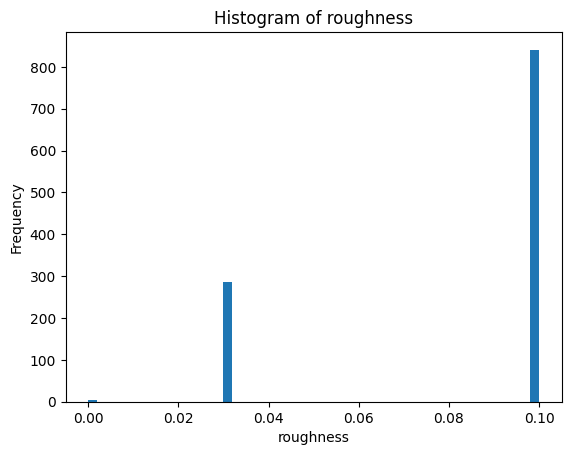

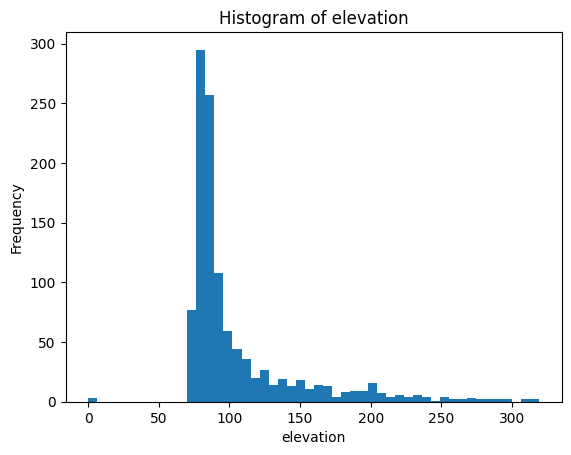

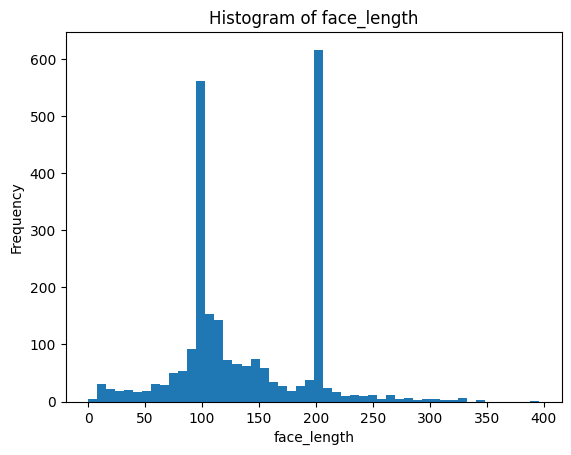

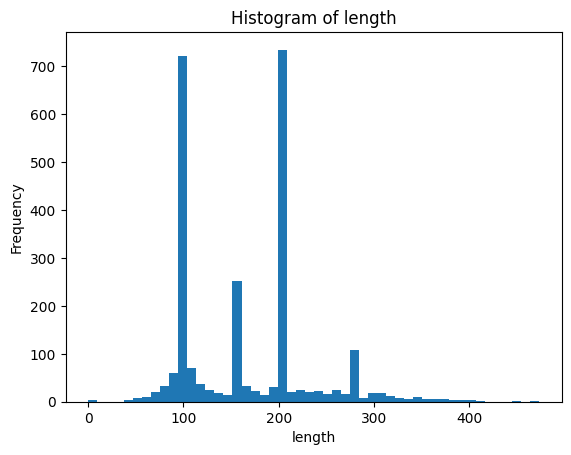

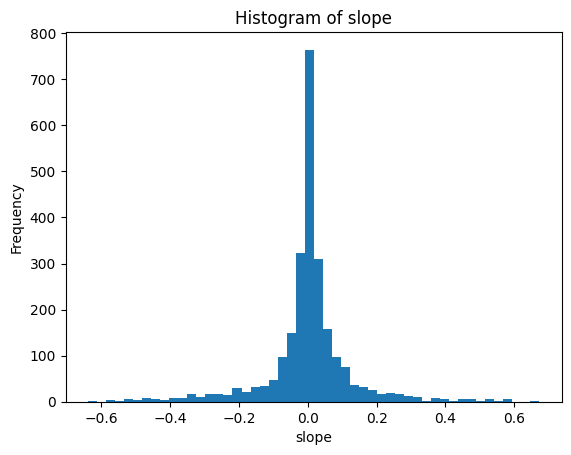

In [10]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEventDataset.STATIC_NODE_FEATURES + FloodEventDataset.STATIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

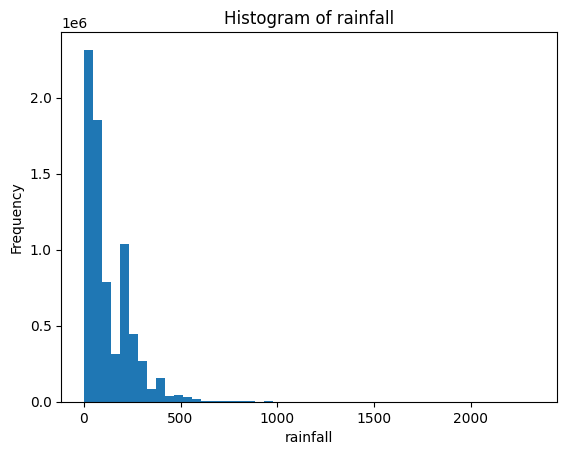

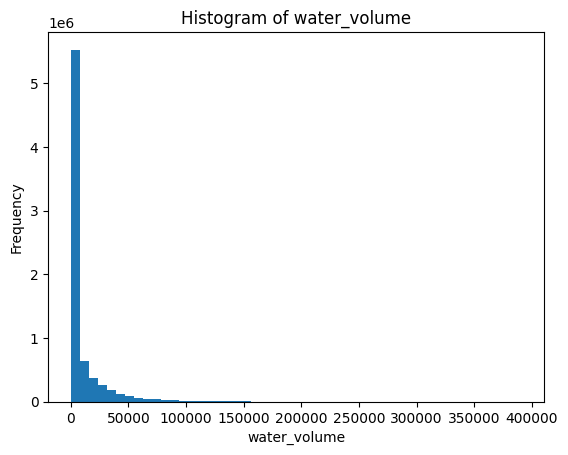

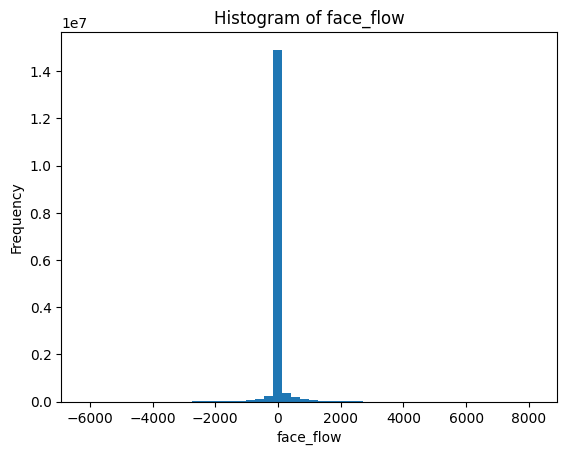

In [11]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEventDataset.DYNAMIC_NODE_FEATURES + FloodEventDataset.DYNAMIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
